This is needed to reload modules without restarting the kernel

In [193]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This is needed to add eda_tools from the directories above

In [194]:
import os
os.sys.path.append('../../')


Base Packages

In [195]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

Base plotting style

In [196]:
import mplhep as hep
hep.set_style('ATLAS')

# Investigating $\Delta \eta_{HH}$ and $X_{HH}$ categorization

Lets investigate what the relationship between $\Delta \eta_{HH}$ and $X_{HH}$ is. To do this we will need the following: 
- signal sample (4b, SR)
- data sample (2b, SR) + Reweighting 

(begin with 2018 for simplicity)

In [6]:
#Signal MC 2018 file_path
file_path_mc_18 = "/mnt/storage/lborgna/NNT/MDR_VEC/mc/mc16e_2b_shiftKR_lshi.root"

In [7]:
#data 2018 file_path
file_path_data_18  = '/mnt/storage/lborgna/NNT/MDR_VEC/data/data_CRVRSR_2B_SRshift_18_NN_100_bootstraps.root'

**Loading Data and signal**

In [8]:
columns_to_load = ['event_number','run_number','ntag','kinematic_region','m_hh','m_h1','m_h2','dEta_hh']

In [9]:
from hh4b_utils.nnt_tools import load_nnt

In [218]:
signal = load_nnt(file_path_mc_18, trees=['sig'], columns=columns_to_load+['mc_sf'])

100%|██████████| 1/1 [00:00<00:00,  5.84it/s]


In [11]:
data = load_nnt(file_path_data_18, trees=['sig'], columns=columns_to_load+['NN_d24_weight_bstrap_med_18'])

100%|██████████| 164/164 [00:24<00:00,  6.70it/s]


In [204]:
from hh4b_utils.nnt_tools import xhh

In [220]:
for _df in [signal, data]:
    _df['Xhh'] = xhh(_df.m_h1.values, _df.m_h2.values, m_h1_center=124, m_h2_center=117)

In [12]:
f_sig = uproot.open(file_path_mc_18)
f_data = uproot.open(file_path_data_18)

In [13]:
from hh4b_utils.nnt_tools import get_mu, get_mu_iqr,w_col

In [14]:
columns_to_load

['event_number',
 'run_number',
 'ntag',
 'kinematic_region',
 'm_hh',
 'm_h1',
 'm_h2',
 'dEta_hh']

In [15]:
norm = get_mu(f_data, 18)

In [16]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832388 entries, 0 to 832387
Data columns (total 9 columns):
event_number                   832388 non-null int64
run_number                     832388 non-null int32
ntag                           832388 non-null int32
kinematic_region               832388 non-null int8
m_hh                           832388 non-null float32
m_h1                           832388 non-null float32
m_h2                           832388 non-null float32
dEta_hh                        832388 non-null float32
NN_d24_weight_bstrap_med_18    832388 non-null float64
dtypes: float32(4), float64(1), int32(2), int64(1), int8(1)
memory usage: 32.5 MB


In [17]:
data['NN_weight'] = norm * data['NN_d24_weight_bstrap_med_18']

In [209]:
lumi=58.45

In [212]:
mask_sig_4b = signal['ntag']>=4

In [324]:
from hh4b_utils.plot_tools import hist2d, hist2d_ratio

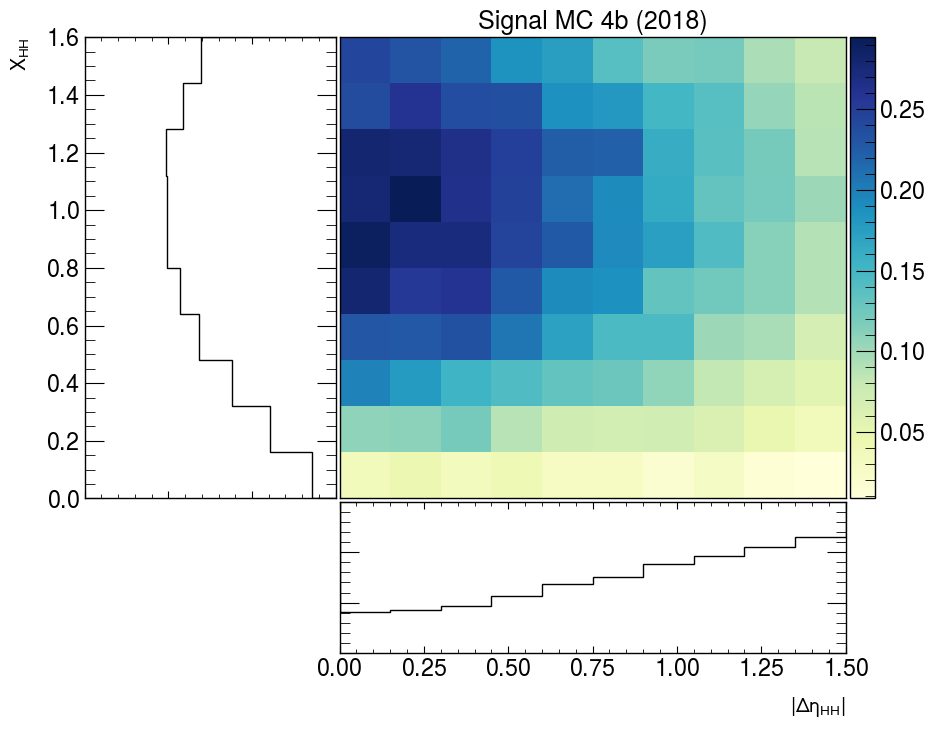

In [337]:
h_sig = hist2d(
    signal.loc[mask_sig_4b, "dEta_hh"].values,
    signal.loc[mask_sig_4b, "Xhh"].values,
    xrange=(0, 1.5),
    yrange=(0, 1.6),
    bins=(10,10),
    axis_hist_on=True,
    weights=lumi * signal.loc[mask_sig_4b,'mc_sf'].values,
    xlabel = r'$|\Delta \eta_{HH}|$',
    ylabel = r'$X_{HH}$',
    title = 'Signal MC 4b (2018)'
)

In [329]:
mask_data_2b = data['ntag']==2

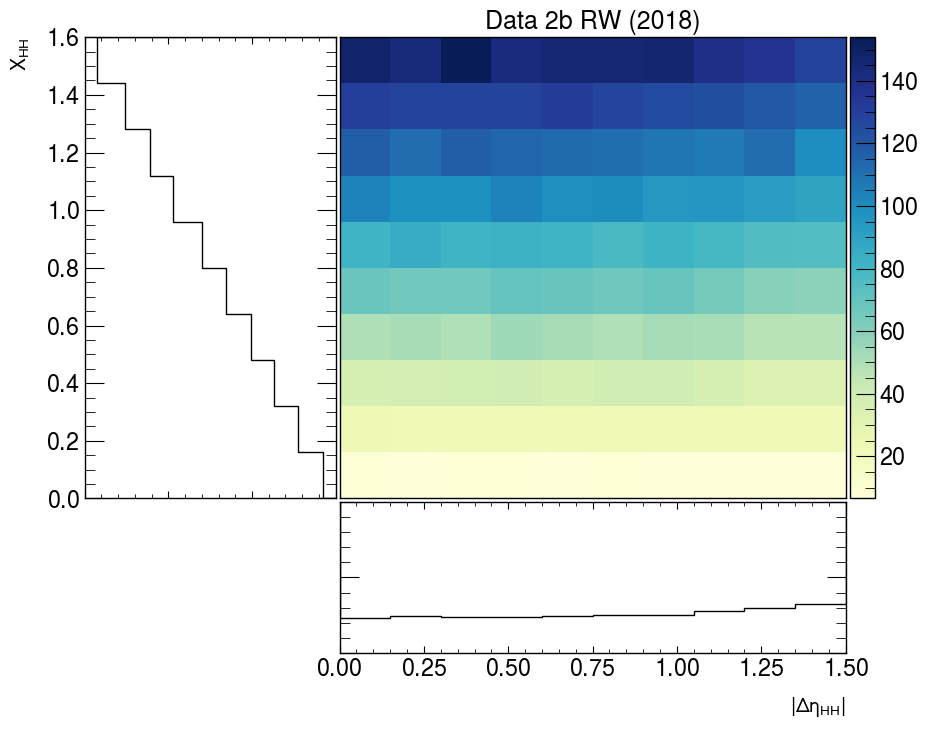

In [330]:
h_bkg = hist2d(
    data.loc[mask_data_2b, 'dEta_hh'].values,
    data.loc[mask_data_2b, 'Xhh'].values,
    xrange=(0,1.5),
    yrange=(0, 1.6),
    bins = (10, 10),
    weights = data.loc[mask_data_2b,'NN_weight'].values,
    xlabel = r'$|\Delta \eta_{HH}|$',
    ylabel = r'$X_{HH}$',
    title = 'Data 2b RW (2018)'
)

In [331]:
soverb = h_sig['h'] / h_bkg['h']

In [332]:
srootb = h_sig['h'] / np.sqrt(h_bkg['h'])

In [333]:
xedges = h_sig['xbins']

In [334]:
yedges = h_sig['ybins']

Text(0.5, 1.0, '$\\frac{signal}{background}$')

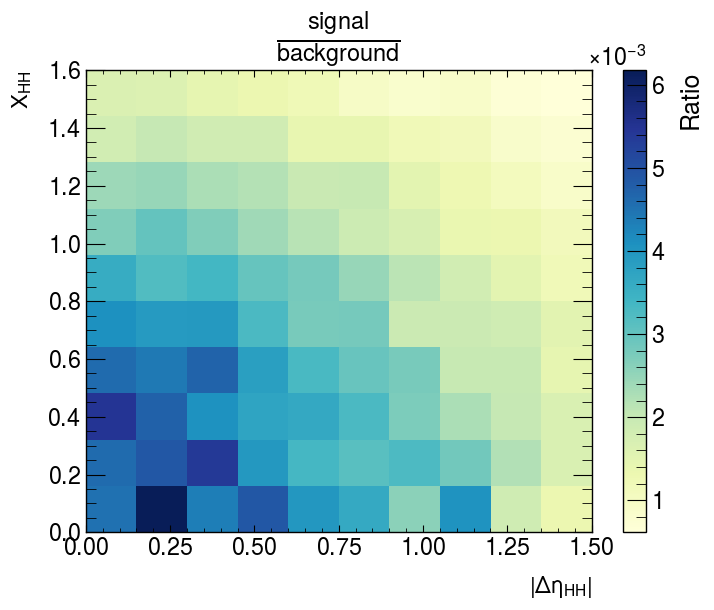

In [335]:
f, ax = plt.subplots()
_=hist2d_ratio(
    soverb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel=r"$|\Delta \eta_{HH}|$",
    ylabel=r"$X_{HH}$",
    colorbar=True
)
ax.set_title(r'$\frac{signal}{background}$')

Text(0.5, 1.0, '$\\frac{signal}{\\sqrt{background}}$')

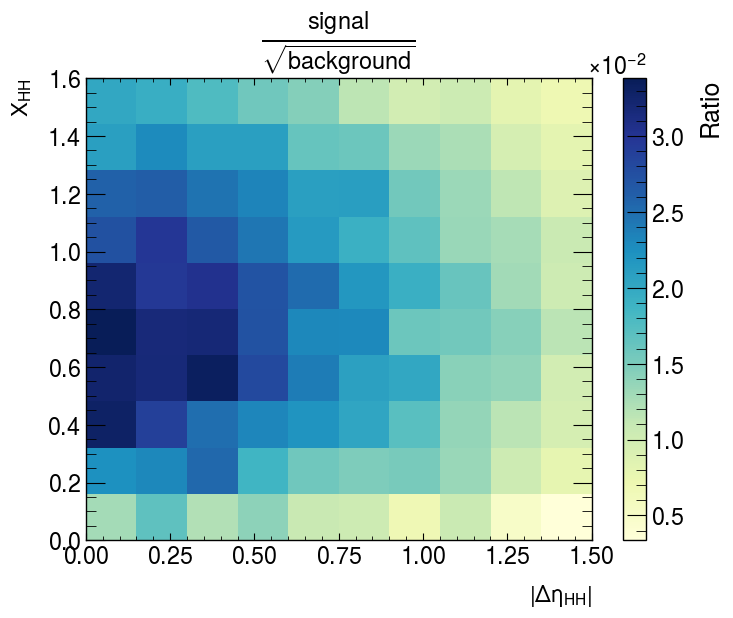

In [336]:
f, ax = plt.subplots()
_=hist2d_ratio(
    srootb,
    ax=ax,
    xedges=xedges,
    yedges=yedges,
    xlabel=r"$|\Delta \eta_{HH}|$",
    ylabel=r"$X_{HH}$",
    colorbar=True
)
ax.set_title(r'$\frac{signal}{\sqrt{background}}$')

# DEBUG

In [20]:
def user_options_undefined(user_options, default_options):

    difference = user_options.keys() - default_options.keys()

    if difference != set():
        raise KeyError(
            "Invalid option passed, ", difference, " is/are not valid options"
        )

In [320]:
def hist2d_test(x, y, **kwargs):
    # Default value of plotting
    options = {
        "figsize": (10, 8),
        "bins": (30, 30),
        "xrange": (20, 200),
        "yrange": (20, 200),
        "weights": np.ones(len(x)),
        "xhisttype": "step",
        "yhisttype": "step",
        "cmap": "YlGnBu",
        "title": "2D plane",
        "xlabel": "$X$",
        "ylabel": "$Y$",
        "axis_hist_on": True,
        "hist_color": "black",
        "filename": "test.png",
        "alpha": 0.7,
        "save": False,
        "show": False,
    }

    user_options_undefined(kwargs, options)

    options.update(kwargs)

    fig = plt.figure(figsize=options["figsize"])

    grid = plt.GridSpec(
        4,
        4,
        hspace=0.02,
        wspace=0.02,
        height_ratios=[1, 1, 1, 1],
        width_ratios=[1, 1, 1, 0.1],
    )
    main_ax = fig.add_subplot(grid[:-1, 1:-1])

    colorbar = fig.add_subplot(grid[:-1, 3])

    h = main_ax.hist2d(
        x,
        y,
        bins=options["bins"],
        range=(options["xrange"], options["yrange"]),
        weights=options["weights"],
        cmap=options["cmap"],
    )
    xbins = h[1]
    ybins = h[2]

    plt.colorbar(h[3], cax=colorbar)

    if options["axis_hist_on"]:
        #y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[])
        #x_hist = fig.add_subplot(grid[-1, 1:-1], yticklabels=[])
        y_hist = fig.add_subplot(grid[:-1, 0],xticklabels=[], sharey=main_ax)
        x_hist = fig.add_subplot(grid[-1, 1:-1],yticklabels=[], sharex=main_ax)
        #main_ax.set_xticks([])
        #main_ax.set_yticks([])

        x_hist.hist(
            x,
            xbins,
            # options["bins"][0],
            color=options["hist_color"],
            #range=options["xrange"],
            histtype=options["xhisttype"],
            weights=options["weights"],
            orientation="vertical",
        )
        x_hist.invert_yaxis()
        x_hist.set_xlabel(options["xlabel"], fontsize=14)

        y_hist.hist(
            y,
            ybins,
            # options["bins"][1],
            color=options["hist_color"],
            #range=options["yrange"],
            histtype=options["yhisttype"],
            weights=options["weights"],
            orientation="horizontal",
        )
        y_hist.invert_xaxis()
        y_hist.set_ylabel(options["ylabel"], fontsize=14)
        #x_hist.set_xlim(options['xrange'])
        #y_hist.set_ylim(options['yrange'][0], options['yrange'][1]+10)
        main_ax.axes.xaxis.set_visible(False)
        main_ax.axes.yaxis.set_visible(False)

    else:
        main_ax.set_xlabel(options["xlabel"], fontsize=14)
        main_ax.set_ylabel(options["ylabel"], fontsize=14)
    main_ax.set_title(options["title"], fontsize=18)
    if options["save"]:
        plt.savefig(options["filename"], dpi=300, bbox_inches="tight")
    if options["show"]:
        plt.show()

    return {"h": h[0], "xbins": h[1], "ybins": h[2], "fig": fig, "main_ax": main_ax}

In [321]:
mask_hm = data['m_hh']>=350

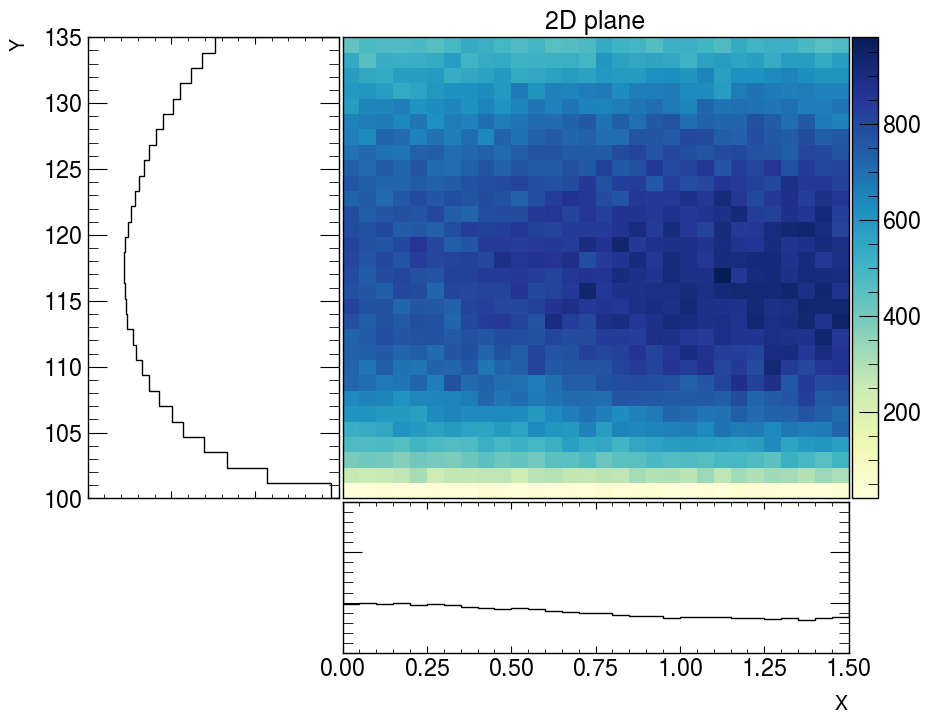

In [322]:
h1 = hist2d_test(
    data.loc[mask_hm, "dEta_hh"].values,
    data.loc[mask_hm, "m_h2"].values,
    xrange=(0, 1.5),
    yrange=(100, 135),
)

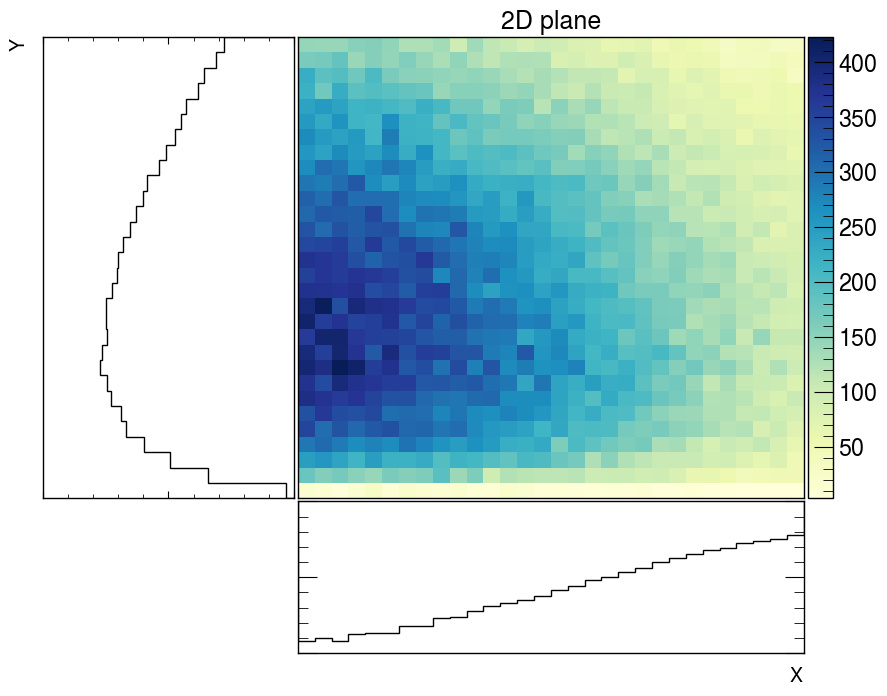

In [323]:
h2 = hist2d(data.loc[~mask_hm,'dEta_hh'].values, data.loc[~mask_hm, 'm_h2'].values, xrange=(0, 1.5), yrange=(100,135))

In [105]:
h1['h']/h2['h']

array([[ 1.17647059,  1.46927374,  1.57723577,  1.63230241,  1.50429799,
         1.81736527,  1.66753927,  1.928     ,  1.83458647,  1.86989796,
         2.01104972,  1.9382716 ,  2.07908163,  2.05835544,  2.25212465,
         2.152     ,  2.37391304,  2.4       ,  2.57654723,  2.29746835,
         2.61774744,  2.73703704,  2.692607  ,  2.4501845 ,  2.58661417,
         2.41908714,  2.70135747,  2.5840708 ,  3.30487805,  2.95862069],
       [ 2.        ,  1.56962025,  1.61328125,  1.53594771,  1.76237624,
         1.68131868,  1.75268817,  2.07038123,  1.79581152,  2.07865169,
         1.84405941,  2.05571031,  1.8452381 ,  2.03466667,  2.0326087 ,
         2.07608696,  2.22636103,  2.56578947,  2.2879257 ,  2.48504983,
         2.58041958,  2.34983498,  2.95454545,  2.53571429,  2.88362069,
         2.56349206,  3.50581395,  2.89417989,  2.72781065,  3.35664336],
       [ 5.5       ,  1.48823529,  1.69456067,  1.64827586,  1.67673716,
         1.72807018,  1.80055402,  1.71246819,  1

In [185]:
def hist2d_ratio(
    R,
    ax=None,
    colorbar=False,
    cmap="YlGnBu",
    vmin=None,
    vmax=None,
    colorbarlabel: str = "Ratio",
    xedges: tuple = (0, 1),
    yedges: tuple = (0, 1),
    xlabel: str = "X",
    ylabel: str = "Y",
) -> dict:
    if ax is None:
        fig, ax = plt.subplots()
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = ax.imshow(
        R.T,
        cmap=cmap,
        extent=extent,
        origin="lower",
        aspect="auto",
        vmin=vmin,
        vmax=vmax,
    )
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)
    if colorbar:
        cbar = plt.colorbar(im, ax=ax)
        # cbar.set_label(colorbarlabel, fontsize=18)
        # cbar.set_label(r"$\frac{4b-2b}{4b}$", fontsize=18)

    return {"ax": ax, "ratio": R, "im": im}

In [186]:
h1['xbins']

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ])

In [187]:
h1['ybins']

array([100.        , 101.16666667, 102.33333333, 103.5       ,
       104.66666667, 105.83333333, 107.        , 108.16666667,
       109.33333333, 110.5       , 111.66666667, 112.83333333,
       114.        , 115.16666667, 116.33333333, 117.5       ,
       118.66666667, 119.83333333, 121.        , 122.16666667,
       123.33333333, 124.5       , 125.66666667, 126.83333333,
       128.        , 129.16666667, 130.33333333, 131.5       ,
       132.66666667, 133.83333333, 135.        ])

In [188]:
h1['xbins'][-1]

1.5

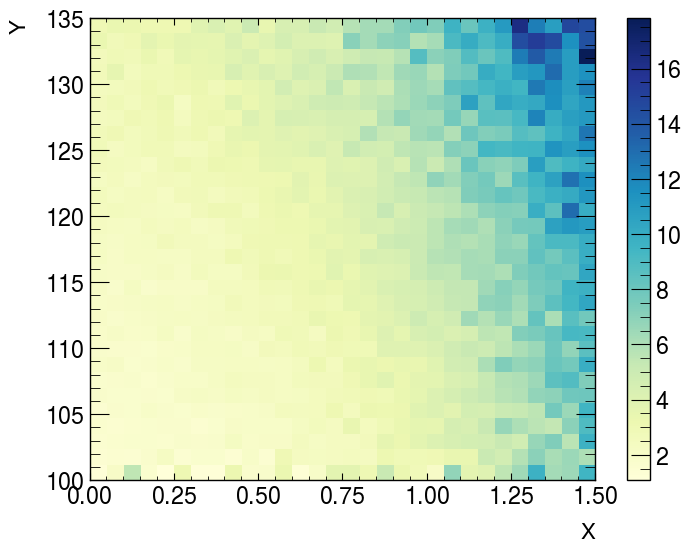

In [189]:
_=massplane_ratio(
    h1["h"] / h2["h"],
    xedges=xedges,
    yedges=yedges,
    colorbar=True,

)


In [182]:
def ratio_plot(R, xbins, ybins,ax):
    extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]]
    
    im = ax.imshow(R.T, cmap= 'YlGnBu', origin = 'lower',extent=extent, aspect='auto')
    cbar = plt.colorbar(im, ax=ax)
    

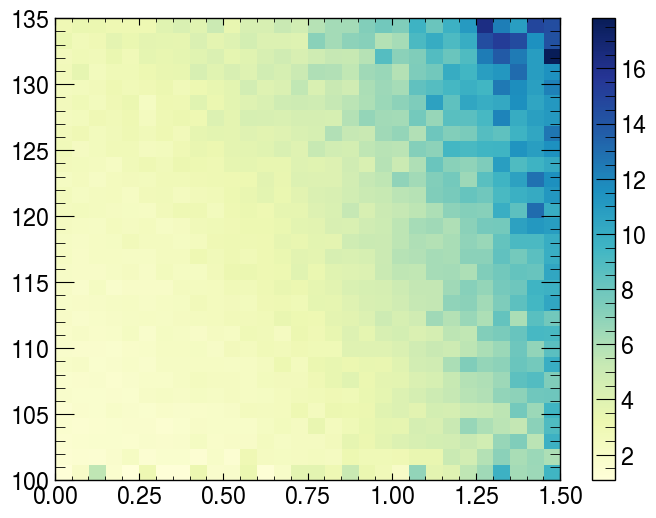

In [183]:
f, ax = plt.subplots()
ratio_plot(R, [0, 1.5], [100, 135],ax)

In [138]:
extent=[0, 1.5, 100, 135]

In [139]:
R = h1['h'] / h2['h']

Text(0.5, 1.0, 'Ratio 4b/2b (Weighted)')

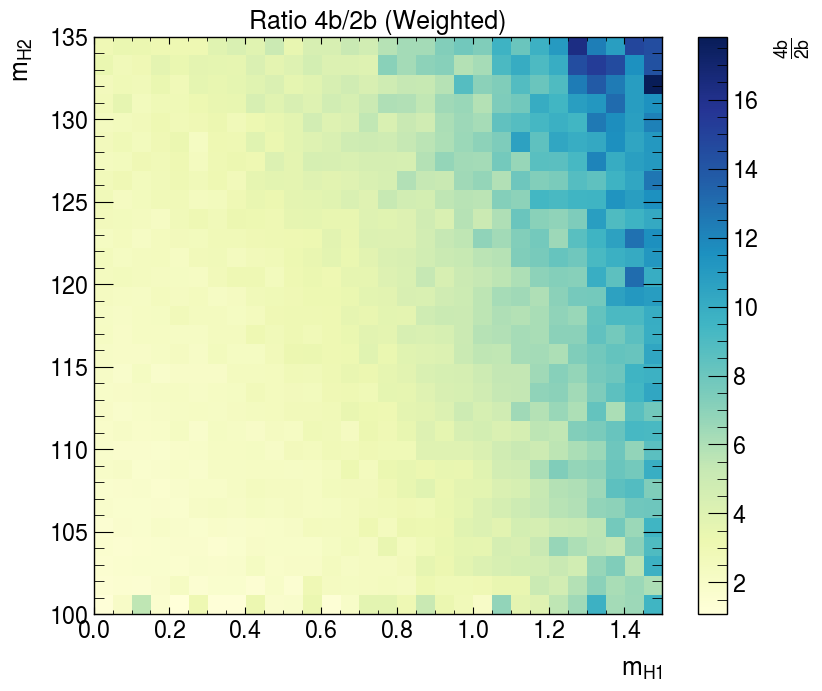

In [114]:
plt.figure(figsize = (9, 7.5))
plt.imshow(R.T, cmap = 'YlGnBu',
           origin = 'lower', extent =extent, aspect = 'auto')
cbar = plt.colorbar()
cbar.set_label(r'$\frac{4b}{2b}$', fontsize = 18)
plt.xlabel('$m_{H1}$', fontsize = 18)
plt.ylabel('$m_{H2}$', fontsize = 18)
plt.title('Ratio 4b/2b (Weighted)', fontsize = 18)

In [148]:
xedges = h1['xbins']
yedges = h1['ybins']

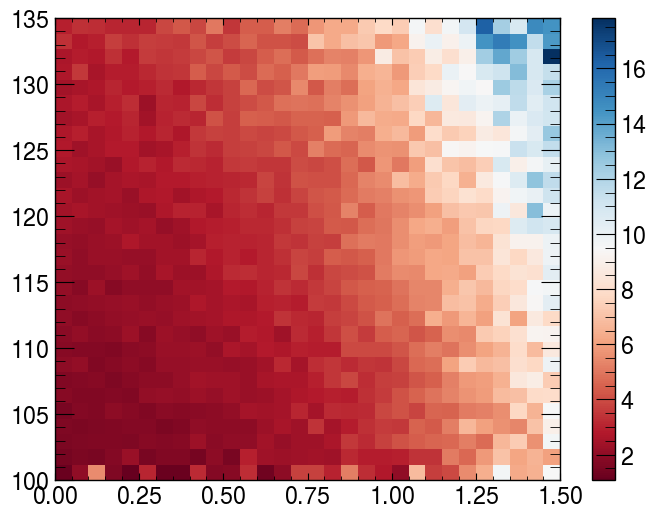

In [158]:
f, ax =plt.subplots()
pc = ax.pcolormesh(xedges, yedges, R.T, cmap = 'RdBu')
f.colorbar(pc, ax=ax)
plt.show()


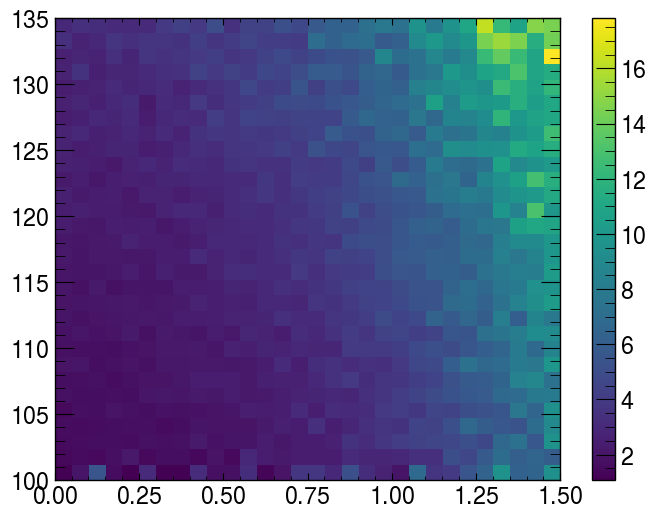

In [154]:
f, ax =plt.subplots()
pc = ax.pcolorfast(xedges, yedges, R.T)
f.colorbar(pc, ax=ax)
plt.show()


In [203]:
from hh4b_utils.plot_tools import hist2d

In [201]:
from hh4b_utils.nnt_tools import load_nnt